In [56]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [32]:
data = pd.read_csv('la_final_data.csv')

In [33]:
display(data.head(3))
print('Shape of original data: \n', data.shape)
print('\n')

data.info()
print('\n')

print('Number of columns of each data type: \n', data.dtypes.value_counts())
print('\n')

isnull_series = data.isnull().sum()[data.isnull().sum() > 0]
print('Columns with null values: \n', isnull_series.sort_values(ascending=False))

,Start_Time,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Target
0,2016-03-22 19:36:44,34.09256,-118.20622,64.0,24.0,30.00,9.2,NaN,False,False,...,False,False,False,False,False,True,False,False,False,1
1,2016-03-22 20:59:43,33.94819,-118.27973,64.0,23.0,30.02,11.5,NaN,False,False,...,False,False,False,False,False,False,False,False,False,1
2,2016-03-23 07:59:47,34.02330,-118.17288,55.9,53.0,30.11,NaN,NaN,False,False,...,True,False,False,False,False,False,False,False,False,1


Shape of original data: 
 (275824, 22)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275824 entries, 0 to 275823
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Start_Time         275824 non-null  object 
 1   Start_Lat          275824 non-null  float64
 2   Start_Lng          275824 non-null  float64
 3   Temperature(F)     275280 non-null  float64
 4   Humidity(%)        275270 non-null  float64
 5   Pressure(in)       275281 non-null  float64
 6   Wind_Speed(mph)    270198 non-null  float64
 7   Precipitation(in)  264554 non-null  float64
 8   Amenity            275824 non-null  bool   
 9   Bump               275824 non-null  bool   
 10  Crossing           275824 non-null  bool   
 11  Give_Way           275824 non-null  bool   
 12  Junction           275824 non-null  bool   
 13  No_Exit            275824 non-null  bool   
 14  Railway            275824 non-null  bool   
 15  Roundabout

In [34]:
data.dropna(axis=0, inplace=True) # drop rows with null

# Extract n-th week, day of week, and hour from 'Start_Time' column
print(data.shape)
data.dropna(subset=['Start_Time'], inplace=True) # drop rows that have null start_time
data['Start_Time'] = pd.to_datetime(data['Start_Time'])
print(data.shape)

data['Start_Month'] = data['Start_Time'].dt.month
data['Start_Hour'] = data['Start_Time'].dt.hour # extract hours from weather_timestamp 
data['Start_Day'] = data['Start_Time'].dt.dayofweek # extract day of week
# data['Start_Num_week'] = data['Start_Time'].dt.isocalendar().week # extract n-th week of the year from to reflect seasonal impacts 

data.drop('Start_Time', axis=1, inplace=True) 

data.head()
data.info()

(263131, 22)
(263131, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 263131 entries, 67 to 275823
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Start_Lat          263131 non-null  float64
 1   Start_Lng          263131 non-null  float64
 2   Temperature(F)     263131 non-null  float64
 3   Humidity(%)        263131 non-null  float64
 4   Pressure(in)       263131 non-null  float64
 5   Wind_Speed(mph)    263131 non-null  float64
 6   Precipitation(in)  263131 non-null  float64
 7   Amenity            263131 non-null  bool   
 8   Bump               263131 non-null  bool   
 9   Crossing           263131 non-null  bool   
 10  Give_Way           263131 non-null  bool   
 11  Junction           263131 non-null  bool   
 12  No_Exit            263131 non-null  bool   
 13  Railway            263131 non-null  bool   
 14  Roundabout         263131 non-null  bool   
 15  Station            26313

In [35]:
# data['Start_Hour'] = data['Start_Hour'].astype(object)
data['Start_Day'] = data['Start_Day'].astype(object)
# data['Start_Num_week'] = data['Start_Num_week'].astype(object)

print('Number of columns of each data type: \n', data.dtypes.value_counts())
print('\n')

isnull_series = data.isnull().sum()[data.isnull().sum() > 0]
print('Columns with null values: \n', isnull_series.sort_values(ascending=False))

Number of columns of each data type: 
 bool       13
float64     7
int64       3
object      1
dtype: int64


Columns with null values: 
 Series([], dtype: int64)


In [36]:
y_target = data['Target'] # target classification label
X_features = data.drop('Target', axis=1, inplace=False)
print(y_target.shape)
print(X_features.shape)

X_features_ohe = pd.get_dummies(X_features)
print(X_features_ohe.shape)

(263131,)
(263131, 23)
(263131, 29)


In [37]:
# Helper function for evaluation
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # add ROC-AUC score
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix: \n', confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f},\
            F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    

In [38]:
# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()
print(y_train.shape)
print(y_test.shape)

(184191, 29)
(78940, 29)
(184191,)
(78940,)


In [39]:
print(y_train.value_counts())
print(y_test.value_counts())

0    144339
1     39852
Name: Target, dtype: int64
0    61749
1    17191
Name: Target, dtype: int64


In [40]:
params = {'C':[0.01, 0.1, 1.0, 10, 100], 'penalty':['l2','none']}

gridsearch = GridSearchCV(estimator=LogisticRegression(), param_grid=params, n_jobs=-1, cv=3, scoring='f1_micro')

# now perform full fit on whole pipeline
gridsearch.fit(X_features_ohe, y_target)
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)
cv_results = gridsearch.cv_results_

Best parameters from gridsearch: {'C': 0.01, 'penalty': 'none'}
CV score=0.879


In [43]:
# Logistic Regression Model
lr_clf = LogisticRegression(C=0.01, penalty='l2')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

In [44]:
# Evaluation of Logistic Regression
get_clf_eval(y_test, lr_pred, lr_pred_proba) 

Confusion Matrix: 
 [[60147  1602]
 [ 8279  8912]]
Accuracy: 0.8748, Precision: 0.8476, Recall: 0.5184,            F1: 0.6433, AUC: 0.9024


In [45]:
X2 = sm.add_constant(X_train.astype(float))
logit_model=sm.GLM(y_train, X2, family=sm.families.Binomial())
result=logit_model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Target   No. Observations:               184191
Model:                            GLM   Df Residuals:                   184163
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52327.
Date:                Sat, 05 Nov 2022   Deviance:                   1.0465e+05
Time:                        14:02:47   Pearson chi2:                 3.71e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               490.8738     11.724     41.870      0.000     467.896     513.852
Start_Lat            -9.9726      0.150    -66.369      0.000     -10.267      -9.678
Start_Lng            -2.7944      0.105    -26.506      0.000      -3.001      -2.588
Temperature(F)       -0.1228      0.001   -104.799      0.000      -0.125      -0.120
Humidity(%)          -0.0520      0.000   -108.538      0.000      -0.053      -0.051
Pressure(in)        -18.1570      0.098   -185.087      0.000     -18.349     -17.965
Wind_Speed(mph)      -0.1758      0.002    -83.421      0.000      -0.180      -0.172
Precipitation(in)     2.8888      0.503      5.739      0.000       1.902       3.875
Amenity               0.0569      0.067      0.847      0.397      -0.075       0.188
Bump                  0.3594      0.936      0.384      0.701      -1.476       2.195
Crossing              0.0175      0.039      0.449      0.654      -0.059       0.094
Give_Way             -0.2164      0.720     -0.301      0.764      -1.627       1.195
Junction             -0.1217      0.025     -4.847      0.000      -0.171      -0.072
No_Exit              -0.0790      0.178     -0.445      0.656      -0.427       0.269
Railway              -0.1108      0.061     -1.827      0.068      -0.230       0.008
Roundabout           -0.0425      0.925     -0.046      0.963      -1.856       1.771
Station               0.1479      0.041      3.566      0.000       0.067       0.229
Stop                 -0.0399      0.058     -0.693      0.488      -0.153       0.073
Traffic_Calming       0.2893      0.822      0.352      0.725      -1.322       1.901
Traffic_Signal        0.0036      0.026      0.137      0.891      -0.048       0.055
Turning_Loop      -3.107e-13   7.74e-15    -40.128      0.000   -3.26e-13   -2.95e-13
Start_Month           0.0953      0.002     39.302      0.000       0.091       0.100
Start_Hour            0.0548      0.001     40.727      0.000       0.052       0.057
Start_Day_0          69.9687      1.675     41.781      0.000      66.686      73.251
Start_Day_1          70.0750      1.675     41.844      0.000      66.793      73.357
Start_Day_2          70.3617      1.675     41.998      0.000      67.078      73.645
Start_Day_3          70.2459      1.675     41.933      0.000      66.963      73.529
Start_Day_4          70.4193      1.675     42.039      0.000      67.136      73.702
Start_Day_5          69.9198      1.675     41.750      0.000      66.637      73.202
Start_Day_6          69.8835      1.675     41.729      0.000      66.601      73.166
=====================================================================================
"""

In [46]:
selected_features = ['Start_Lat', 
                     'Start_Lng',
                     'Temperature(F)', 
                     'Humidity(%)',
                     'Pressure(in)', 
                     'Wind_Speed(mph)',
                     'Precipitation(in)',
                     'Junction', 
                     'Railway', 
                     'Station', 
                     'Turning_Loop', 
                     'Start_Month', 
                     'Start_Hour', 
                     'Start_Day_0', 
                     'Start_Day_1', 
                     'Start_Day_2',
                     'Start_Day_3', 
                     'Start_Day_4', 
                     'Start_Day_5', 
                     'Start_Day_6']

In [47]:
y_target = data['Target'] # target classification label
X_features_ohe = X_features_ohe[selected_features]

print(X_features_ohe.shape)

(263131, 20)


In [48]:
# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()
print(y_train.shape)
print(y_test.shape)

(184191, 20)
(78940, 20)
(184191,)
(78940,)


In [49]:
# Logisitc Regression model hyperparameter tuning
params = {'C':[0.01, 0.1, 1.0, 10, 100], 'penalty':['l2','none']}

gridsearch = GridSearchCV(estimator=LogisticRegression(), param_grid=params, n_jobs=-1, cv=3, scoring='f1_micro')

# now perform full fit on whole pipeline
gridsearch.fit(X_features_ohe, y_target)
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)
cv_results = gridsearch.cv_results_

Best parameters from gridsearch: {'C': 10, 'penalty': 'l2'}
CV score=0.879


In [50]:
# Logistic Regression Model
lr_clf = LogisticRegression(C=10, penalty='l2')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

In [51]:
# Evaluation of Logistic Regression
get_clf_eval(y_test, lr_pred, lr_pred_proba) 

Confusion Matrix: 
 [[59252  2497]
 [ 6702 10489]]
Accuracy: 0.8835, Precision: 0.8077, Recall: 0.6101,            F1: 0.6952, AUC: 0.9014


In [53]:
# Random Forest model hyperparameter tuning
params = {'max_depth': [20, 40],
          'min_samples_split': [2, 5, 10]}

gridsearch = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100), param_grid=params, n_jobs=-1, cv=3, scoring='f1_micro')

# now perform full fit on whole pipeline
gridsearch.fit(X_features_ohe, y_target)
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)
cv_results = gridsearch.cv_results_

Best parameters from gridsearch: {'max_depth': 40, 'min_samples_split': 2}
CV score=0.979


In [54]:
# Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=40, min_samples_split=2)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_pred_proba = rf_clf.predict_proba(X_test)[:,1]

# Evaluation of Random Forest
get_clf_eval(y_test, rf_pred, rf_pred_proba) 

Confusion Matrix: 
 [[61645   104]
 [  537 16654]]
Accuracy: 0.9919, Precision: 0.9938, Recall: 0.9688,            F1: 0.9811, AUC: 0.9996


In [57]:
# XGBOOST hyperparameter tuning
params = {'max_depth': [5, 7],
          'min_child_weight': [1, 3],
          'colsample_bytree': [0.5, 0.75]}

gridsearch = GridSearchCV(estimator=XGBClassifier(n_estimators=100), param_grid=params, n_jobs=-1, cv=3, scoring='f1_micro')

# now perform full fit on whole pipeline
gridsearch.fit(X_features_ohe, y_target)
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)
cv_results = gridsearch.cv_results_

Best parameters from gridsearch: {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1}
CV score=0.998


In [58]:
# XGBOOST model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=7, min_child_weight=1, colsample_bytree=0.75)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_pred_proba = xgb_clf.predict_proba(X_test)[:,1]

# Evaluation of XGBOOST model
get_clf_eval(y_test, xgb_pred, xgb_pred_proba) 

Confusion Matrix: 
 [[61740     9]
 [   50 17141]]
Accuracy: 0.9993, Precision: 0.9995, Recall: 0.9971,            F1: 0.9983, AUC: 1.0000


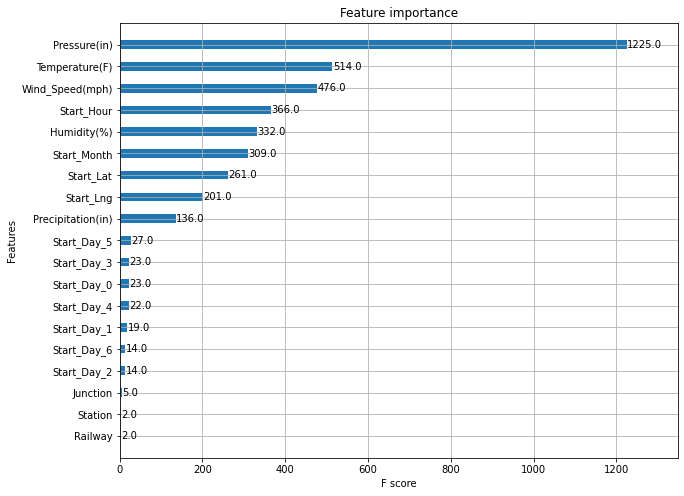

In [61]:
from xgboost import plot_importance

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()